### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL - Exercise Sheet #09

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy

## Preparation: Load data

In [2]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)


selected CSP components:[50  0 49 48  1 47]


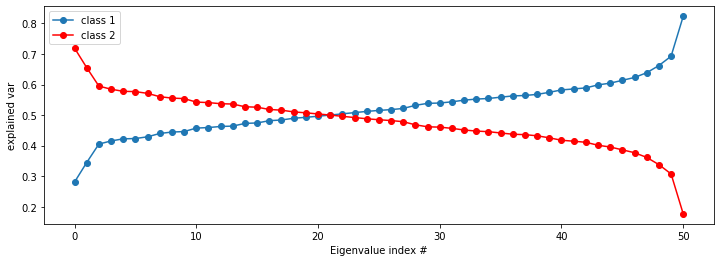

In [3]:
def train_CSP(epo, mrk_class):
    ''' 
    Usage:
        W, d = trainCSP(epo, mrk_class)
    Parameters:
        epo:   a 3D array of segmented signals (samples x channels x epochs)
        mrk_class: a 1D array that assigns markers to classes (0, 1)
    Returns:
        W:     matrix of spatial filters
        d:     vector of generalized Eigenvalues
    '''
    C = epo.shape[1]
    X1 = np.reshape(np.transpose(epo[:,:,mrk_class==0], (1,0,2)), (C, -1))
    S1 = np.cov(X1)
    X2 = np.reshape(np.transpose(epo[:,:,mrk_class==1], (1,0,2)), (C, -1))
    S2 = np.cov(X2)	
    d, W = scipy.linalg.eigh(a=S1, b=S1+S2)
    return W, d

band = [10.5, 13]
Wn = band / fs * 2
b, a = sp.signal.butter(5, Wn, btype='bandpass')
cnt_bp = sp.signal.lfilter(b, a, cnt)
epo, epo_t = bci.makeepochs(cnt_bp, fs, mrk_pos, [750, 4000])

W, d = train_CSP(epo, mrk_class)

plt.figure(figsize=[12,4])
plt.plot(d,'-o',label='class 1')
plt.plot(1-d,'r-o',label='class 2')
plt.xlabel('Eigenvalue index #')
plt.ylabel('explained var')
plt.legend()

selected_csps = np.flipud(np.argsort(np.maximum(d,1-d)))[:6]
print('selected CSP components:' +str(selected_csps))

C = epo.shape[1]
X = np.reshape(np.transpose(epo, (1,0,2)), (C, -1))
cov_X = np.cov(X)
S=np.dot(W.T,epo)
cov_S=np.cov(np.dot(W.T,X))
d_csp = d[selected_csps]
A = np.dot( np.dot(cov_X,W),np.linalg.inv(cov_S))
A_csp = A[:, selected_csps] # spatial patterns
W_csp = W[:, selected_csps] # spatial filters

cnt_csp = np.dot(W_csp.T, cnt_bp) # CSP-filtered signals. ## 2nd step

## Exercise 1: Validation of CSP-based Classification  (6 points)
This task is a continuation of the exercises on sheet \#08 and uses the same dataset. <br>
Classification can be performed using log band-power features of the CSP filtered and segmented signals.  Use the same frequency-band, time-interval and selection of six CSP filters (as charaterized by the index) as on the previous sheet. Estimate the generalization error of the whole classification procedure using six feature dimensions using 3-fold cross-validation. <br/>
*Take into account what was said in the lecture about validating a CSP-based method!*

In [4]:
ival = [750, 4000]
epo_csp, epo_csp_t = bci.makeepochs(cnt_csp, fs, mrk_pos, ival)

print(epo_csp.shape)

epo_csp = np.log(np.var(epo_csp,axis=0,keepdims=1))
print(epo_csp.shape)

epo_csp=epo_csp.squeeze()
print(epo_csp.shape)

(326, 6, 280)
(1, 6, 280)
(6, 280)


In [5]:
loss_test, loss_train = cfy.crossvalidation(cfy.train_LDA, epo_csp, mrk_class, folds=3, verbose=True)
print(loss_test)
print(loss_train)
# The generalization error is the difference between the expected and empirical error ---- TEST DATA TURSIM

  2.5 +/- 1.4  (training:  1.8 +/- 0.9)  [using train_LDA]
2.5311585987051823
1.796676634302614


## Exercise 2: Split-half validation of CSP (4 points)
Use the same frequency band and time interval as before.
1. Determine the CSP filters on the *first half* of the data and plot the Eigenvalues in the same way as in exercises 2 of the previous sheet. (Presumably, the result will look quite similar.)
2. You know from the lecture, that the Eigenvalues correspond to a ratio of variances. Calculate this corresponding ratio of variance as trial averages: Apply all 51 CSP filters to the data and calculate the variance in each trial. Average the variance for all trials of the first half separately for the two classes. Calculate the ratio of the average variance in class 1 divided by the sum of the average variances in both classes. Visualize the result in a plot like the Eigenvalues. 
3. Plot the variance ratio as in (2), but this time calculated from the trials of the second half of the data (while still using the CSP filters that were determine on the first half).

Investigate and discuss the difference between the plots.

(326, 51, 280)
(326, 51, 140)
(51,)


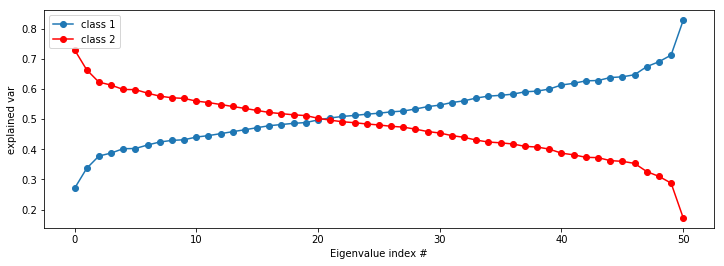

In [8]:
band = [10.5, 13]
ival = [750, 4000]
Wn = band / fs * 2
b, a = sp.signal.butter(5, Wn, btype='bandpass')
cnt_bp = sp.signal.lfilter(b, a, cnt)

epo, epo_t = bci.makeepochs(cnt_bp, fs, mrk_pos, ival)
print(epo.shape)

epo_1st_half = epo[:,:,:epo.shape[2]//2]
print(epo_1st_half.shape)

W_1st_half, d_1st_half = train_CSP(epo_1st_half, mrk_class[:mrk_class.shape[0]//2])
csps_1st_half = np.flipud(np.argsort(np.maximum(d_1st_half,1-d_1st_half)))

plt.figure(figsize=[12,4])
plt.plot(d_1st_half,'-o',label='class 1')
plt.plot(1-d_1st_half,'r-o',label='class 2')
plt.xlabel('Eigenvalue index #')
plt.ylabel('explained var')
plt.legend()
print(d_1st_half.shape)

(51, 280)
(51, 140)


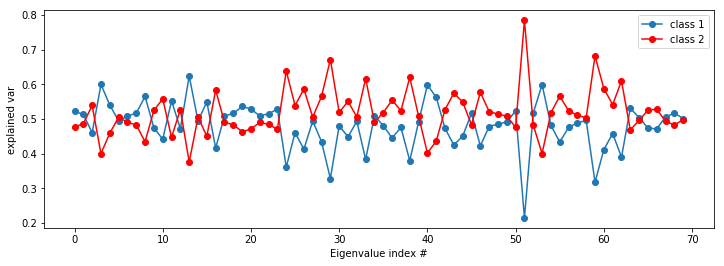

In [43]:
#Calculate this corresponding ratio of variance as trial averages: 
    #Apply all 51 CSP filters to the data and calculate the variance in each trial.
C = epo.shape[1]
X = np.reshape(np.transpose(epo, (1,0,2)), (C, -1))
cov_X = np.cov(X)

S = np.dot(W_1st_half.T,epo)
cov_S = np.cov(np.dot(W_1st_half.T,X))

d_csp = d_1st_half[csps_1st_half]

A_1st_half = np.dot( np.dot(cov_X,W_1st_half),np.linalg.inv(cov_S))

A_csp = A_1st_half[:, csps_1st_half]
W_csp = W_1st_half[:, csps_1st_half]

cnt_csp = np.dot(W_csp.T, cnt_bp)

epo_csp, epo_t = bci.makeepochs(cnt_csp, fs, mrk_pos, ival)
epo_csp = np.var(epo_csp,axis=0,keepdims=1)
epo_csp = epo_csp.squeeze()
print(epo_csp.shape)

    #Average the variance for all trials of the first half separately for the two classes.
epo_csp_1st_half = epo_csp[:,:epo_csp.shape[1]//2]
print(epo_csp_1st_half.shape)

average_0 = np.average(epo_csp_1st_half[:,mrk_class[:mrk_class.shape[0]//2]==0],axis=0)
average_1 = np.average(epo_csp_1st_half[:,mrk_class[:mrk_class.shape[0]//2]==1],axis=0)

    #Calculate the ratio of the average variance in class 1 divided by the sum of the average variances in both classes. 
ratio = average_1 / (average_0+average_1)


   #Visualize the result in a plot like the Eigenvalues.
plt.figure(figsize=[12,4])
plt.plot(ratio,'-o',label='class 1')
#plt.plot(1-ratio,'r-o',label='class 2')
plt.xlabel('Eigenvalue index #')
plt.ylabel('explained var')
plt.legend()

(51, 140)


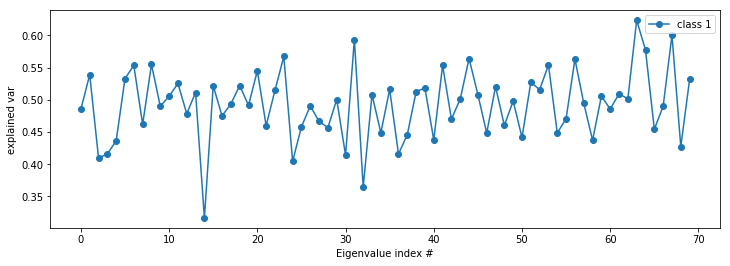

In [50]:
# Plot the variance ratio as in (2), but this time calculated from the trials of the second half of the data 
# (while still using the CSP filters that were determine on the first half)

epo_csp_2nd_half = epo_csp[:,epo_csp.shape[1]//2:]
print(epo_csp_2nd_half.shape)


aaverage_0 = np.average(epo_csp_2nd_half[:,mrk_class[mrk_class.shape[0]//2:]==0],axis=0)
aaverage_1 = np.average(epo_csp_2nd_half[:,mrk_class[mrk_class.shape[0]//2:]==1],axis=0)

rratio = aaverage_1 / (aaverage_0+aaverage_1)


   #Visualize the result in a plot like the Eigenvalues.
plt.figure(figsize=[12,4])
plt.plot(rratio,'-o',label='class 1')
#plt.plot(1-ratio,'r-o',label='class 2')
plt.xlabel('Eigenvalue index #')
plt.ylabel('explained var')
plt.legend()

## Exercise 3: Classification using power spectral density features  (5 points)
Calculate the power spectral density (PSD, see sheet #07) in the interval 1000-5000 ms for all channels. Keep only the PSD values for the frequencies from 6 to 26 Hz. Concatenate those PSD values for all channels to obtain feature vectors. Estimate the performance of this classification approach using cross-validation.<br/>
Repeat the same procedure, this time applying the Laplace filter for selected channels (your choice, at least six) before calculating the PSD.

In [6]:
def plot_PSD(cnt, fs, mrk_pos, mrk_class, ival):
    epo, _ = bci.makeepochs(cnt, fs, mrk_pos, ival)
    X1 = epo[:, 0, mrk_class==0]
    X2 = epo[:, 0, mrk_class==1]
    f1, X1psd = sp.signal.welch(X1.flatten('F'), fs=fs)
    f2, X2psd = sp.signal.welch(X2.flatten('F'), fs=fs)

    plt.semilogy(f1, X1psd)
    plt.semilogy(f2, X2psd)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [$uV^2$/Hz]')

In [35]:
ival = [1000, 5000]
epo, _ = bci.makeepochs(cnt, fs, mrk_pos, ival)
X1 = epo[:, 0, mrk_class==0]
X2 = epo[:, 0, mrk_class==1]
f1, X1psd = sp.signal.welch(X1.flatten('F'), fs=fs)
f2, X2psd = sp.signal.welch(X2.flatten('F'), fs=fs)

f1_cond = [i>=6 and i<=26 for i in f1]
f2_cond = [i>=6 and i<=26 for i in f1]

# get the values in the frequency range
x1 = X1psd[f1_cond == True]
x2 = X2psd[f2_cond == True]

print (x1)

[]
